# <span style="color:#183059"> Implementazione di un compressore multibanda</span>
### <span style="color:#183059"> Mario Sguario</span>

## <span style="color:#183059">1) Nozioni fondamentali:</span>
### <span style="color:#183059">     Cos'è un segnale audio</span>

Un segnale audio è la variazione della pressione dell'aria nel tempo, nel mondo digitale i segnali continui vengono misurati nel tempo con una certa frequenza tramite un operazione chiamata campionamento.
Un segnale campionato è composto da samples o campioni che variano in ampiezza; possiamo dunque pensare ad un segnale audio come un array unidimensionale che immagazzina per ogni istante l'ampiezza misurata.

### <span style="color:#183059">     Dominio delle frequenze</span>
Come tutti i segnali unidimensionali, i segnali audio possono essere rappresentati nel dominio del tempo o nel dominio delle frequenze. Nel dominio delle frequenze, i segnali audio sono scomposti in componenti sinusoidali di diverse frequenze e ampiezze.

Le frequenze più basse risultano in sinusoidi con periodo più ampio, viceversa le frequenze più alte.

Possiamo trasformare un segnale dal dominio del tempo a quello delle frequenze usando la **Trasformata di Fourier**:

<div style="text-align: center;">
    <div style="display: flex; justify-content: center; align-items: center;">
        <img src="Imgs/SignalTempo.png" alt="Signal in tempo domain" style="width: 600px; display: block; margin: 0 auto;"/>
        <div style="display: flex; flex-direction: column; align-items: center; margin: 0 5px;">
            <span style="font-size: 18px; font-weight: bold;">FT</span>
            <span style="font-size: 24px;">-></span>
        </div>
        <img src="Imgs/SignalFreq.png" alt="Signal in frequency domain" style="width: 600px; display: block; margin: 0 auto;"/>
    </div>
</div>



## <span style="color:#183059">-2) Signal processing di audio musicali: </span>

### <span style="color:#183059"> Effetti per segnali musicali:</span>

Ad i segnali digitali, come per quelli analogici si possono applicare svariati effetti che ci permettono di modificare il segnale a nostro piacimento, io mi focalizzerò sui segnali musicali.

### <span style="color:#183059"> Importanza degli effetti ed il loro utilizzo:</span>
Quasi la totalità delle tracce audio vengono processate digitalmente per migliorarne la resa, quindi con molta probabilità ognuno di voi oggi ha ascoltato un qualche audio processato con effetti come Equalizzatori, Compressori, De-esser, Riverberi, Delay ecc..

Questi effetti sono particolarmente importanti nella produzione musicale, tant'è che le due fasi finali della produzione di un qualsiasi brano (ovvero Mixing e Mastering), consistono nel applicare effetti alle tracce audio, con l'obbiettivo di migliorarne il volume generale, la traducibilità sui vari sistemi di ascolto ecc..



## <span style="color:#183059">-3) Compressione multibanda: </span>

Per parlare di compressione multibanda bisogna prima parlare di compressione, la quale non ha nulla a che fare con la compressione delle dimensioni dei file cha tutti conosciamo.

### <span style="color:#183059">     Cos'è un compressore?</span>

Il compressore è uno strumento che ci permette di attenuare i picchi di un segnale audio che superano una certa **soglia** (treshold) di una quantità data dal rapporto segnale ed una **ratio**

Ci permette di ridurre la troppa **dinamica** in un suono 

(**Dinamica** = differenza tra i momenti più tenui con quelli con più volume)

Riducendo i picchi del segnale si guadagnerà più **headroom** ovvero più spazio 'libero' per altri suoni, inoltre si avrà un suono più coeso.
Avendo più headroom si può anche alzare di volume il segnale senza incorrere in distorsioni, ottenendo un suono complessivamente più forte.

### <span style="color:#183059">     Cos'è un compressore multibanda?</span>

Un compressore multibanda è un tipo di compressore dinamico che divide il segnale audio in più bande di frequenza e applica la compressione in modo indipendente a ciascuna banda.

Per farlo utilizzad dei crossover che separano il segnale audio in più bande;
Un crossover è sostanzialmente l’insieme di un filtro passa basso e un filtro passa alto, una banda è il range frequenziale risultante dalla separazione dell’intero spettro sonoro in porzioni più piccole 



## <span style="color:#183059">-4) Implementazione</span>

Per prima cosa definiamo funzioni ausiliarie e funzioni per il plot dei risultati:

In [31]:
######################## IMPORTS ########################
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from scipy.signal import lfilter, butter, cheby1
import IPython
from IPython.display import Audio
import math


################### FUNZIONI AUSILIARIE ###################
def normalize(signal):
    max_amplitude = np.max(np.abs(signal))
    signal = signal / max_amplitude
    return signal

def stereo2mono(signal):
    if len(signal.shape) > 1:
        return np.mean(signal, axis=1)
    else:
        return signal

def calculate_FT(signal, s_rate):
    N_samples = len(signal)
    F_sound = np.fft.fft(signal) / N_samples
    F_freq = np.fft.fftfreq(N_samples, 1/s_rate)
    return F_sound, F_freq

def writeOnFile(file_name, s_rate, signal):
    #Creo o sovrascrivo il file dove mettterò l'audio
    with open(file_name, "w") as file:
        output_file = file_name
    #Scrivo nel file
    wav.write(output_file, s_rate, signal)
    return

################### FUNZIONI DI PLOT ###################
    
def plotFreqDomain(signal, s_rate, title):
    F_sound, F_freq = calculate_FT(signal, s_rate)
    plt.plot(F_freq, np.abs(F_sound))
    plt.title(title)
    plt.xlabel('Frequenza (Hz)')
    plt.ylabel('Magnitude')
    plt.grid()
    
def plotLogFreqDomain(sound1, s_rate1,label1,sound2, s_rate2,label2, crossovers):
    ## Calcoliamo la trasformata di Fourier
    F_1,freq1 = calculate_FT(sound1, s_rate1)
    F_2,freq2 = calculate_FT(sound2, s_rate2)

    plt.figure(figsize=(10, 4))
    plt.plot(freq1, np.abs(F_1), label=label1, color='blue',alpha=0.6)  
    plt.plot(freq2, np.abs(F_2), label=label2, color='red',alpha=0.6) 
    
    for crossover in crossovers:
        plt.axvline(crossover, color='black', linestyle='--', linewidth=1)
            
    plt.xlabel('Frequenza [Hz]')
    plt.ylabel('Amplitude [db]')
    plt.title('Visulizzazione non lineare (Equalizzatore)')
    plt.xscale('symlog', linthresh=100, linscale=0.1)
    plt.yscale('log') 

    plt.xlim([20,2e4])
    plt.ylim([0.2e-5, 1e-2])
    custom_ticks = [20, 100, 200, 500, 1000, 2000, 5000, 10000, 15000,20000]
    plt.xticks(custom_ticks, custom_ticks)
    plt.tight_layout()
    plt.legend()
    plt.grid()

def plotMBCompEffect(sound_bands, compressed_sound_bands, s_rate, thresholds, attack_times, release_times):
    if len(sound_bands) != len(compressed_sound_bands):
        print('Errore: Numero di bande non corrispondente')
        return
    num_plots = len(sound_bands)
    fig, axes = plt.subplots(num_plots, 1, figsize=(12, 6*num_plots))
    
    for i in range(num_plots):
        env = envelope_follower(sound_bands[i], attack_times[i], release_times[i], s_rate)
        
        time = np.linspace(0, len(sound_bands[i]) / s_rate, len(sound_bands[i]))
        axes[i].plot(time, sound_bands[i], color='blue', alpha=0.6, label='Original')
        axes[i].plot(time, compressed_sound_bands[i], color='red', alpha=0.6, label='Compressed')
        axes[i].plot(time, env, color='green', alpha=0.6, label='Envelope')
        axes[i].plot(time, np.ones_like(time) * thresholds[i], color='black', linestyle='--', label='Threshold')
        axes[i].set_title('Band ' + str(i+1))
        axes[i].set_xlabel('Tempo (s)')
        axes[i].set_ylabel('Amplitude')
        axes[i].grid()
        axes[i].legend()
        axes[i].set_xlim([0, 4])
        
    
        # Plot compression curve
        ax_compression = axes[i].inset_axes([0, -0.3, 1, 0.3])
        ax_compression.plot(time, np.abs(sound_bands[i] - compressed_sound_bands[i]))
        ax_compression.set_xlabel('Tempo (s)')
        ax_compression.set_ylabel('Compression')
        ax_compression.grid()
        ax_compression.set_xlim([0, 4])
        
    plt.tight_layout()
    plt.show()

### <span style="color:#183059"> Compressione</span>

Questo è il chart che descrive il comportamento di un compressore data una soglia ed una ratio

<img src="Imgs/CompChart.png" width="500px">

Ad esempio se la ratio del compressore è 3:1 e il segnale ha 6 db di volume, e si ha una treshold di 3 db.
Sappiamo che il volume sopra la treshold è di 3 db e dovrà diventare 1/3 di quello che era -> 1db. Dunque il segnale compresso avrà un ampiezza di 4db

<br>

**Come riproduciamo questo effetto digitalmente?**

Una implementazione semplificata del compressore consisterebbe nel prendere il segnale e comprimere tutti i sample che superano il valore della soglia.

<img src="Imgs/DrySignal.png" width="1000px">

Ma come notiamo il segnale assume ampiezze sia positive che negative, per ovviare a questo problema possiamo definire un nuovo segnale dato dal valore assoluto o dalla radice media quadrata (RMS) del segnale originale.
<br>

Il segnale originale verrà compresso solo se il segnale in valore assoluto supererà la soglia.

Questo è il risultato:

<img src="Imgs/CompWrong.png" width="1000px">

Notiamo però che quando il segnale interseca la soglia si genera un punto angoloso che produrrebbe una distorsione del segnale.

<br>

Vorremmo invece che tutto il segnale vicino a dove eccede la treshold venga compresso, in questo modo:


<img src="Imgs/CompRigth.png" width="1000px">

### <span style="color:#183059"> Envelope Follower</span>

Per fare in modo che ciò accada vorremmo avere un segnale che segua l'andamento generale del nostro input,
<br>
Questo nuovo segnale viene chiamato **envelope** e viene generato da un **envelope follower**.

Intuitivamente dovremmo ridurre le oscillazioni del segnale, come facciamo ad avere un segnale più smooth? 

**Riduciamo le frequenze alte**    ->    **Low pass filter**

<td style="text-align: center;"><img src="Imgs/LowPass.png" alt="Env Image" style="width: 300px;"/></td>

Ci serve un filtro dunque simile ad un passa basso, che però risponda più velocemente ad i cambiamenti:

<td style="text-align: center;"><img src="Imgs/EnvFollower.png" alt="Lowpass Image" style="width: 300px;"/></td>



Per implementarlo dichiariamo due variabili:

**ATK** = Il valore di attacco ovvero quanto velocemente l'inviluppo seguirà il segnale quando il segnale sale.

**REL** = Il valore di rilascio ovvero quanto velocemente l'inviluppo seguirà il segnale quando il segnale scende.

A questo punto possiamo scrivere la formula:

$$
\text{For each sample } i \text{ in Signal:}
$$

$$
Env[i] = 
\begin{cases} 
    Env[i-1] \cdot ATK + (1-ATK) \cdot Signal[i] & \text{if } Signal[i] \geq Env[i-1] \\
    Env[i-1] \cdot REL + (1-REL) \cdot Signal[i] & \text{if } Signal[i] < Env[i-1]
\end{cases}
$$

Questo non ci permette solo di implementare una funzione che segua l'inviluppo di un segnale ma anche modificare a piacimento i due parametri per modificare l'effetto della compressione:

Con un attacco più alto la compressione partirà dopo lasciando il cosidetto transiente inalterato, con un rilascio più alto andremo a ridurre più lentamente la curva del'envelope effettivamente comprimento anche dopo che il segnale è tornato sotto al livello della soglia.


Inviluppo con attacco e rilascio veloci

<img src="Imgs/Fast.png" width="1000px">

Inviluppo con attacco e rilascio lenti

<img src="Imgs/Slow.png" width="1000px">

A questo punto si può finalmente comprimere il segnale correttamente:

Compressione con parametri veloci

<img src="Imgs/FastComp.png" width="1000px">

Compressione con parametri lenti

<img src="Imgs/SlowComp.png" width="1000px">

Sebbene si potrebbe pensare che è sempre più desiderabile avere parametri veloci, per sfruttare al meglio la compressione e dunque riavere più headroom nella musica molte volte non è così in quanto in generale si tende a lasciare il **transiente** del suono invariato per mantenere la 'pacca' iniziale.

Nella realtà durante il missaggio di un brano questi parametri vengono modificati su misura per ogni segnale per affinarne al massimo la resa.

In [32]:
######################## FUNZIONI COMPRESSIONE ########################
def envelope_follower(signal, attack_time, release_time, s_rate):
    
    if attack_time == 0:
        attack_time = 0.00000001
    
    attack_time = attack_time / 1000
    release_time = release_time / 1000
    
    attack_coef = math.pow(math.exp(-1/attack_time), 1/s_rate)
    release_coef = math.pow(math.exp(-1/release_time), 1/s_rate)

    envOut = np.zeros_like(signal)
    for i in range(1, len(signal)):
        envIn = np.abs(signal[i])
        
        if signal[i] >= envOut[i-1]:
            envOut[i] = attack_coef * envOut[i-1] + (1 - attack_coef) * envIn
        else:
            envOut[i] = release_coef * envOut[i-1] + (1 - release_coef) * envIn
    return envOut


def compressor(signal, s_rate, threshold, ratio, attack_time, release_time):
    
    env = envelope_follower(signal, attack_time, release_time, s_rate)

    compressed = np.zeros_like(signal)
    for i in range(len(signal)):

        if env[i] > threshold:
            compression_ammount = (env[i] - threshold) / ratio
            compression_factor = (threshold + compression_ammount) / env[i]
            compressed[i] = signal[i] * compression_factor
        else:
            compressed[i] = signal[i]  
    return compressed

### <span style="color:#183059"> Divisione in bande</span>
Non ci resta che dividere in bande a nostro piacimento; <br>
Una volta diviso il segnale in bande possiamo applicare una normale compressione ad ognuna di esse.

In [33]:
################## FUNZIONI COMPRESSIONE MULTIBANDA ####################

#Filtraggio del segnale Butterworth
def butterFilter(signal, s_rate, cutoff, order, btype):
    nyquist = 0.5 * s_rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype=btype, analog=False)
    return lfilter(b, a, signal)

#Filtraggio del segnale Chebyshev
def chebyshevFilter(signal, s_rate, cutoff, order, btype):
    rp = 0.5
    nyquist = 0.5 * s_rate
    normal_cutoff = cutoff / nyquist
    b, a = cheby1(order, rp, normal_cutoff, btype=btype, analog=False)
    return lfilter(b, a, signal)
    
#Generatore di banda
def bandGenerator(signal, s_rate, freq):
    if freq < 200 or freq > 18000:
        print('Errore: Frequenza non valida')
        return
    x = 4 * freq / 100
    low_signal = chebyshevFilter(signal, s_rate, freq-x, 6, btype='low')
    high_signal = chebyshevFilter(signal, s_rate, freq+x, 6, btype='high')
    low_signal = np.nan_to_num(low_signal)
    high_signal = np.nan_to_num(high_signal)
    return low_signal , high_signal

#Divisore del segnale in varie bande di frequenza
def divideSignal(signal, s_rate, crossovers):
    sorted(crossovers)
    aux=signal
    signals = []
    for i in range(len(crossovers)):
        low, high = bandGenerator(aux, s_rate, crossovers[i])
        aux = high
        signals.append(low)
    signals.append(high)
    return signals

#Unione delle bande dopo la compressione
def mergeSignals(signals):
    merged = signals[0]
    for i in range(1, len(signals)):
        merged = merged + signals[i]
    return merged
      

#Compressore multibanda
def multibandCompressor(signal, s_rate, crossovers, thresholds, ratios, attacks, releases):
    if len(crossovers)+1 != len(thresholds) or len(thresholds) != len(ratios):
        print('Errore: Parametri errati')
        return
    #Divido il segnale in bande di frequenza
    signals = divideSignal(signal, s_rate, crossovers)
    toMerge = []
    

    for i in range(len(signals)):
        #Applico la compressione
        toMerge.append(compressor(signals[i], s_rate, thresholds[i], ratios[i], attacks[i], releases[i]))
        
    plotMBCompEffect(signals, toMerge, s_rate, thresholds, attacks, releases)
    #Riunisco le bande in un unico segnale
    merged = mergeSignals(toMerge)
    return merged

### <span style="color:#183059"> Esecuzione nel main</span>

Applico compressione multibanda


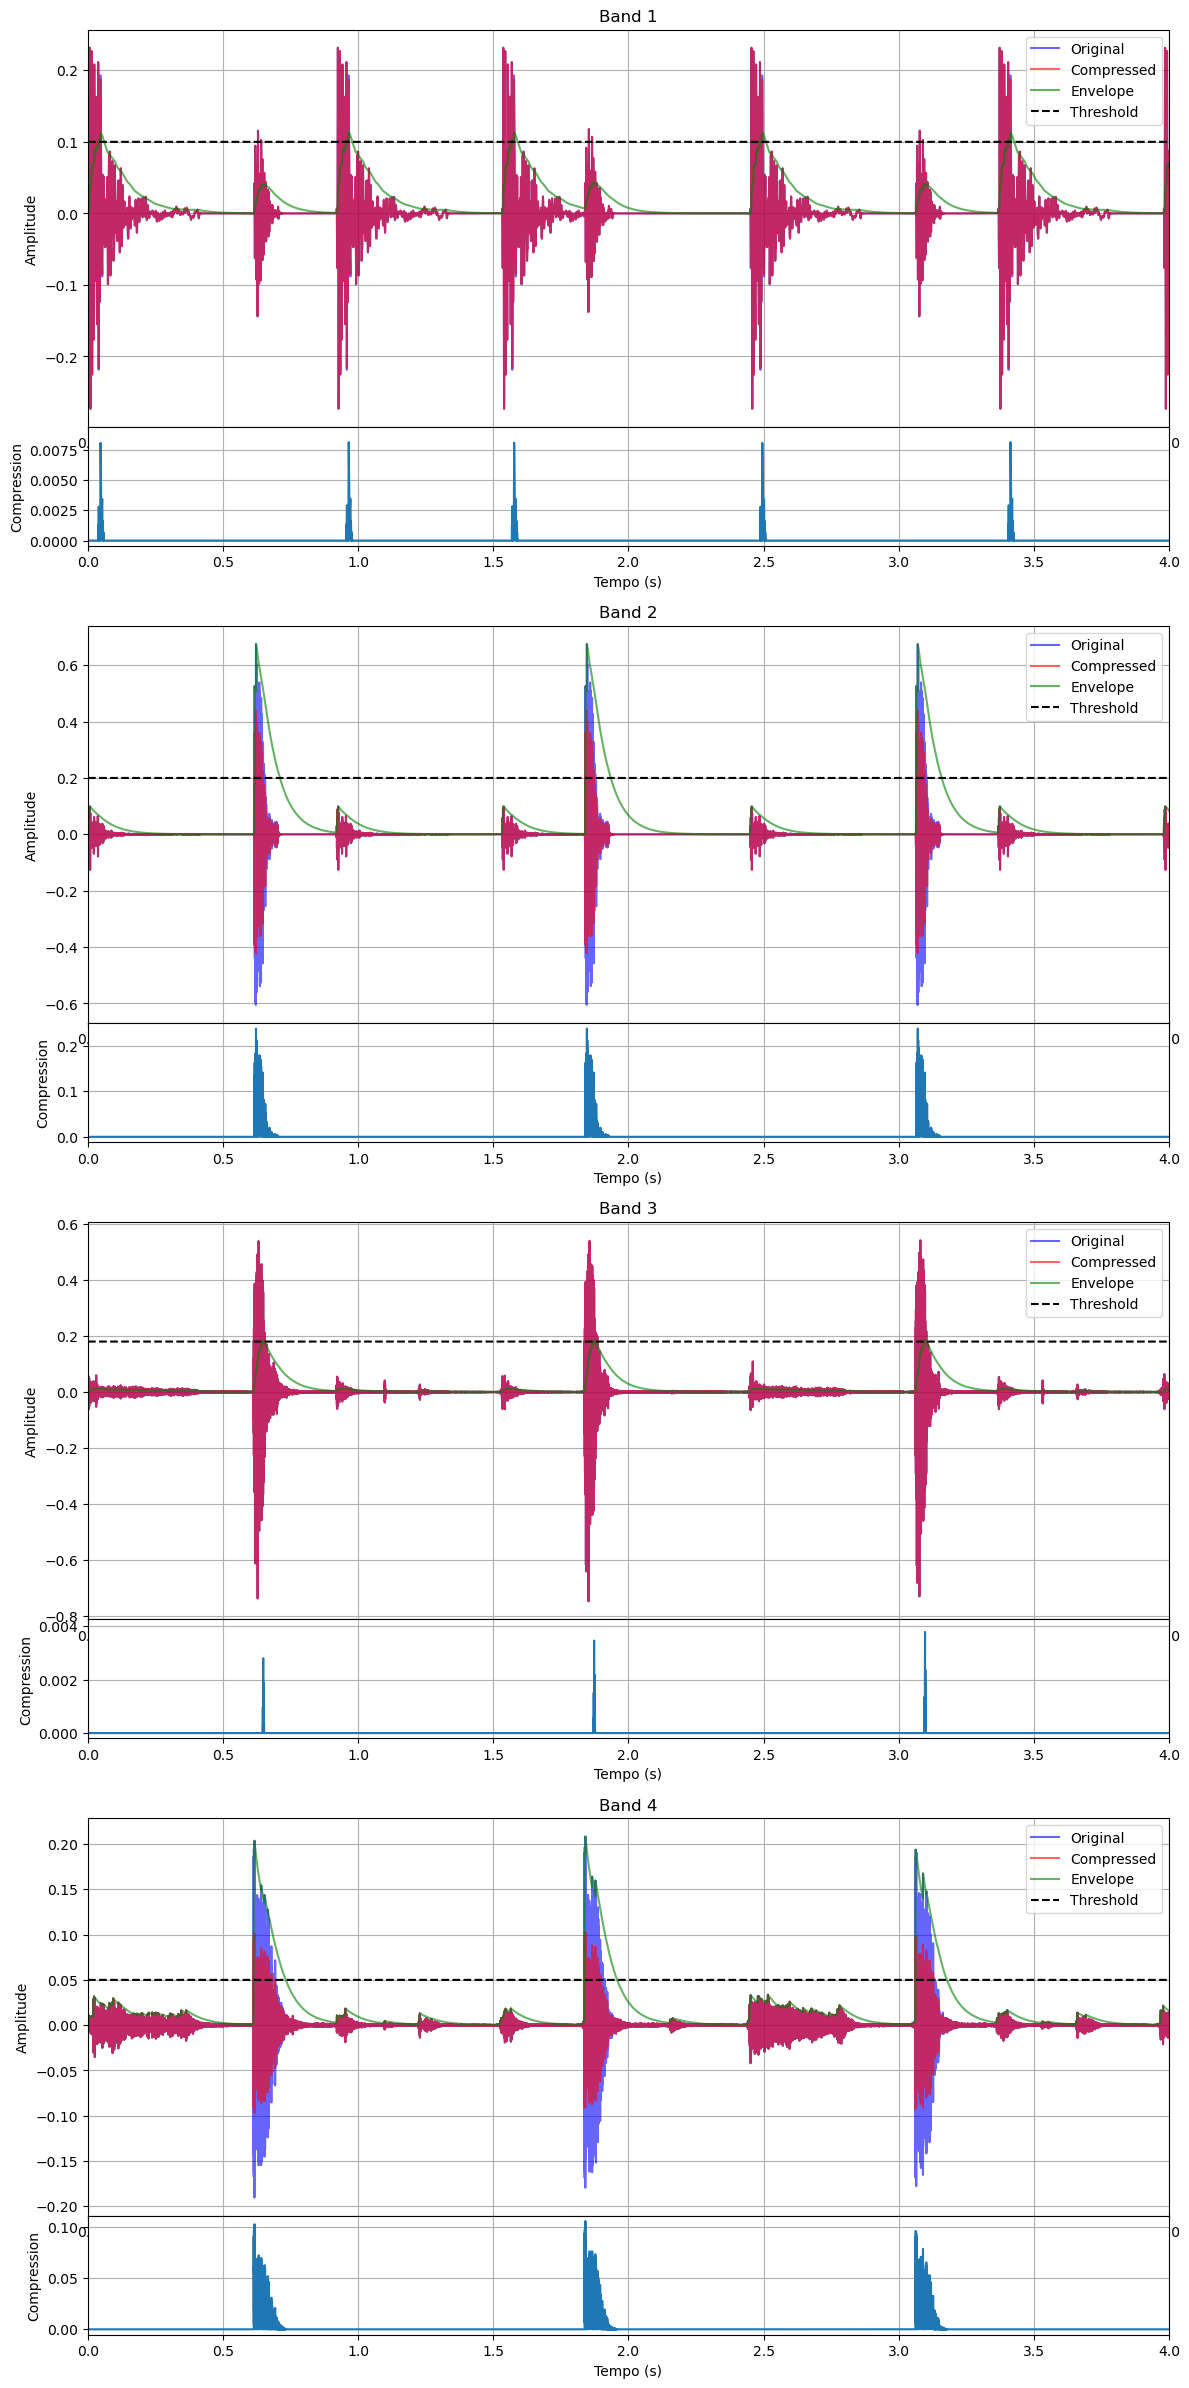

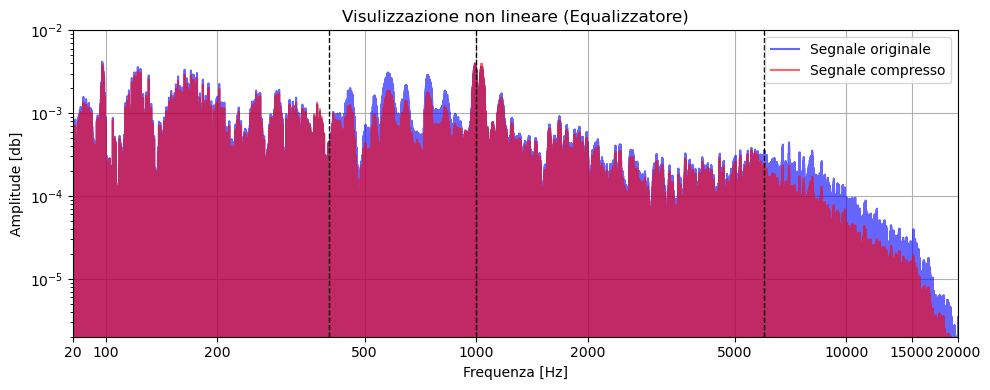

In [34]:
######################## CODICE ########################

#Importo l'audio
input_file = 'Audios/drums.wav'

#Scompongo il suono in sample rate e segnale 
s_rate, drum_sound = wav.read(input_file) 

drum_sound = stereo2mono(drum_sound)

#Trovo il numero di sample e la lunghezza del segnale
N_samples= len(drum_sound) 
duration = N_samples / s_rate

#Normalizzo il segnale
drum_sound = normalize(drum_sound)

#Calcolo la trasformata di Fourier
ft_drums, freq_drums = calculate_FT(drum_sound, s_rate)

#Inizializzo i parametri per la compressione multibanda

#Expressed in Hz
crossovers = np.array([400, 1000, 6000])
#Expressed in values €[-1,1] since amplitude has been normalized
thresholds = np.array([0.1, 0.2, 0.18, 0.05])
#Expressed as an integer
ratios = np.array([2,2,2,3])

#Expressed in seconds
    #Attacco da 0 a 200 millisecondi
attacks = np.array([10,0,10,0])
    #Rilascio da 5 a 5000 millisecondi
releases = np.array([60,60,60,60])


print('Applico compressione multibanda')
compressed_drum_sound = multibandCompressor(drum_sound, s_rate, crossovers, thresholds, ratios, attacks, releases)
#Applico la normalizzazione al segnale compresso per rialzae l'ampiezza in quanto la compressione ha generato headroom
compressed_drum_sound = normalize(compressed_drum_sound)

signals = [drum_sound, compressed_drum_sound]
titles = ['Segnale originale', 'Segnale compresso']

plotLogFreqDomain(drum_sound, s_rate, 'Segnale originale', compressed_drum_sound, s_rate, 'Segnale compresso', crossovers)

Ora sentiamo le differenze:

In [35]:
IPython.display.display(Audio(drum_sound, rate=s_rate))

In [36]:
IPython.display.display(Audio(compressed_drum_sound, rate=s_rate))